# RSSI Indoor localisation dataset generator

This is an example code to synthetically generate RSSI data for indoor localisation in random house settings. The parameters that can be controlled are the following:

- n_rooms: Number of rooms.
- largest_distance: Largest distance between any pair of rooms (in units).
- room_size: Width and lenght per room
- n_locations: Number of visited locations per room (eg. 5 locations in each room)
- n_sensors: Number of RSSI receiver sensors

- sensor_locations: List of room names indicating the existence of a sensor in corner (0,0)
- room_names: List of room names in the house

The RSSI values are computed given the X,Y positions in each room, the distance between rooms, the position of the receiver sensors, and random noise per sensor using the following path loss model [1]

$$RSS = -10n\log(D) + C$$

where:

- D: Is the euclidean distance from the sensor to the x,y position
- n: Is the loss of the environment
- C: Is a constant sensor intrinsic loss

```
[1] P. Kumar, L. Reddy, and S. Varma, “Distance measurement and error estimation scheme for RSSI based localization in wireless sensor networks,” in 5th International Conference on Wireless Communication and Sensor Networks, WCSN-2009, 2009, pp. 80–83.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

class RandomHouse(object):
    """Random house generator
    
    This class generates a random house with various rooms and
    receiver sensors, and allows to generate walk-arounds with
    corresponding RSSI values per receiver. The generated house
    layout may be impossible, as the distances, and connections
    between rooms does not have constrains during the generation.

    Parameters
    ----------
    n_rooms : int, default=7
        Number of rooms

    largest_distance : int, default=40
        Maximum distance between different rooms

    min_size : int, default=3
        Minimum width/lenght of a room

    max_size : int, default=7
        Maximum width/lenght of a room

    n_sensors : int, default=4
        Number of sensors (must be smaller than number of rooms)

    random_seed : int or None
        If a random_seed is provided, the house layout and the rest of
        parameters will allways generate the same data


    Attributes
    ----------
    walkaround_dict : dictionary of walkarounds
        A walkaround is a dictionary with one key per room_name and the following values
            locations: matrix (n_locations, 2)
                Several locations inside the room with x and y coordinates
                with respect to the south-west room
            straight_path: matrix (n_locations*samples_between_locations, 2)
                Contains linear interpolations between each location visited in the
                room in x, y coordinates with respect to the south-west corner of the
                room.
            path: matrix (n_locations*samples_between_locations, 2)
                Corresponds to the straight path with added noise in the coordinates
                simulating movement of the RSSI emisor.
    room_names: list of strings
        Name of each room of the house (eg. bedroom, bedroom2, bathroom, kitchen)

    sensor_locations: list of strings
        Name of each room that contains a sensor receiver

    sensor_constant_loss: list of ints
        Randomly generated list of losses in dB for each sensor. This simulates
        imperfections on each receiver as well as other losses given its location

    room_dimesions: list of tuples
        One tuple per room containing width and length of the room

    distance_m: matrix (n_rooms, n_rooms)
        Matrix with distances between each pair of rooms symettric agains the diagonal
        and with zeros in the diagonal. These are not walking distances, but in a
        straight line.

    adjacency_m: matrix (n_rooms, n_rooms)
        Matrix indicating connections between each pair of rooms

    walls_loss_m: matrix (n_rooms, n_rooms)
        Matrix with loss in dB between each pair of rooms, simulating different
        properties of the walls (eg. thickness, material, objects).

    number_of_experiments: int
        Number of walkarounds retrieved/generated

    Examples
    --------
    >>> house = RandomHouse(n_rooms=7, random_seed=42)
    >>> walkaround = house.retrieve_walkaround(number=0)
    >>> X_rssi, y = house.get_sensor_rssi(number=0)
    """
    def __init__(self, n_rooms=7, largest_distance=40,
                 min_size=3, max_size=7, n_sensors=4, random_seed=None):
        self.n_rooms = n_rooms
        self.largest_distance = largest_distance
        self.random_seed = random_seed
        self.n_sensors = n_sensors
        self.walkaround_dict = {}

        self.room_names = self.generate_room_names()
        self.sensor_locations = self.generate_sensor_locations()
        self.sensor_constant_loss = self.generate_sensor_constant_losses()
        self.room_dimensions = self.generate_room_dimensions(min_size, max_size)
        self.distance_m = self.generate_distance_matrix()
        
        from scipy.sparse.csgraph import minimum_spanning_tree
        self.adjacency_m = minimum_spanning_tree(self.distance_m).toarray().astype(bool) + np.eye(n_rooms)

        self.walls_loss_m = self.generate_walls_loss_matrix()
        
        
    @property
    def number_of_experiments(self):
        return len(self.walkaround_dict)
    
    def generate_room_names(self):
        np.random.seed(self.random_seed)
        basic_rooms = ['bedroom', 'livingroom', 'bathroom', 'kitchen']
        additional_rooms = ['bedroom', 'hall', 'stairs', 'corridor', 'toilet', 'garage', 'study']

        n_basic_rooms = self.n_rooms if self.n_rooms < len(basic_rooms) else len(basic_rooms)
        n_addit_rooms = max([0, self.n_rooms - n_basic_rooms])

        room_names = list(np.random.choice(basic_rooms, n_basic_rooms, replace=False))
        for new_room in np.random.choice(additional_rooms, n_addit_rooms, replace=True):
            suffix = ''
            i = 1
            while new_room + suffix in room_names:
                i += 1
                suffix = str(i)
            room_names.append(new_room + suffix)
        return room_names
    
    def generate_room_dimensions(self, min_size=2, max_size=8):
        np.random.seed(self.random_seed)
        return np.random.randint(min_size, max_size, size=(self.n_rooms, 2))
    
    def generate_sensor_locations(self):
        np.random.seed(self.random_seed)
        return np.random.choice(self.room_names, self.n_sensors, replace=False)
    
    def generate_sensor_constant_losses(self):
        np.random.seed(self.random_seed)
        return np.random.randint(2, 10, self.n_sensors)
    
    def generate_distance_matrix(self):
        np.random.seed(self.random_seed)
        distance_m = np.triu(np.random.randint(1, self.largest_distance,
                                               size=(self.n_rooms, self.n_rooms)), +1)
        i_lower = np.tril_indices(self.n_rooms, -1)
        distance_m[i_lower] = distance_m.T[i_lower]
        return distance_m
    
    def generate_walls_loss_matrix(self):
        np.random.seed(self.random_seed)
        walls_m = np.triu(np.random.randint(2, 12,
                                            size=(self.n_rooms, self.n_rooms)), +1)
        i_lower = np.tril_indices(self.n_rooms, -1)
        walls_m[i_lower] = walls_m.T[i_lower]
        return walls_m
    
    def retrieve_walkaround(self, number=0, n_locations=5, samples_inbetween=10):
        if (number in self.walkaround_dict) and \
           (self.walkaround_dict[number][self.room_names[0]]['path'].shape[0] == n_locations*samples_inbetween):
            return self.walkaround_dict[number]

        self.walkaround_dict[number] = {}
        for i, (room_name, room_size) in enumerate(zip(self.room_names, self.room_dimensions)):
            if (self.random_seed is not None) and (number is not None):
                random_seed = self.random_seed + number + i
            else:
                random_seed = None
            walkaround = {}
            walkaround['locations'] = self.get_locations(room_size, n_locations, random_seed=random_seed)
            walkaround['straight_path'] = self.get_fine_locations(walkaround['locations'],
                                                                  inbetween=samples_inbetween)
            walkaround['path'] = self.add_walking_noise(walkaround['straight_path'], room_size,
                                                         random_seed=random_seed)
            self.walkaround_dict[number][room_name] = walkaround
        return self.walkaround_dict[number]
    
    def walkaround_as_x_y(self, number, key):
        X = []
        y = []
        for i, (room_name, walkaround) in enumerate(self.walkaround_dict[number].items()):
            X.append(walkaround[key])
            y.append(np.ones(walkaround[key].shape[0], dtype=int)*i)
        X = np.vstack(X)
        y = np.hstack(y).astype(int)
        return X, y
    
    def get_sensor_rssi(self, number, key='path', min_value=-120):
        def path_loss_model(distances, environment_loss, system_loss):
            return -10*environment_loss*np.log10(distances) - system_loss

        X_dist, y = self.get_sensor_distances(number, key)
        X_rssi = []
        for i in range(self.n_sensors):
            if self.random_seed is not None:
                np.random.seed(self.random_seed+i)
            environment_loss = np.abs(np.random.randn(X_dist.shape[0]))*3 + self.walls_loss_m[i, y]
            current_rssi = path_loss_model(X_dist[:,i], environment_loss,
                                           self.sensor_constant_loss[i])
            current_rssi[current_rssi < -np.random.randint(50, -min_value)] = np.nan
            X_rssi.append(current_rssi)
        X_rssi = np.vstack(X_rssi).T
        return X_rssi, y
    
    def get_sensor_distances(self, number, key='path'):
        X, y = self.walkaround_as_x_y(number, key)
        eucl_distances = np.sqrt(np.sum(X**2, axis=1))
        X_dist = []
        for i in range(self.n_sensors):
            distances = eucl_distances + self.distance_m[i][y]
            X_dist.append(distances)
        X_dist = np.vstack(X_dist).T
        return X_dist, y
    
    @staticmethod
    def get_locations(room_size, n_locations, random_seed=None):
        np.random.seed(random_seed)
        return np.vstack([np.random.uniform(0, max_size, size=n_locations)
                                        for max_size in room_size]).T
    @staticmethod
    def get_fine_locations(locations, inbetween=10):
        long_locations = [locations[0].reshape(1, -1),]
        for i, current in enumerate(locations, 1):
            along_x = np.linspace(long_locations[-1][-1][0], current[0], inbetween)
            along_y = np.linspace(long_locations[-1][-1][1], current[1], inbetween)
            long_locations.append(np.vstack((along_x,along_y)).T)
        return np.vstack(long_locations)
    
    @staticmethod
    def add_walking_noise(locations, room_size, random_seed=None):
        np.random.seed(random_seed)
        locations += np.random.randn(locations.shape[0], locations.shape[1])/6
        locations = np.clip(locations, (0+0.3, 0+0.3), (room_size[0]-0.3, room_size[1]-0.3))
        return locations
        

def draw_matrix(m, labels, title=None):
    fig, ax = plt.subplots()
    ax.set_title(title)
    im = ax.imshow(m, cmap='viridis')
    if len(np.unique(m)) > 2:
        fig.colorbar(im)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels, rotation=45, ha='right')
    ax.set_ylim(len(labels)-0.5, -0.5)
    
from matplotlib.patches import Rectangle
from matplotlib import cm
def plot_room_walkaround(locations, room_size, title=None, sensor=False, lines=True, dots=True):
    if not lines and not dots:
        return
    n_locations = locations.shape[0]
    fig, ax = plt.subplots()
    ax.set_title(title)
    cmap = cm.get_cmap('Blues')

    rect = Rectangle((0, 0), room_size[0], room_size[1],linewidth=1, edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    if dots:
        ax.scatter(locations[:,0], locations[:,1], color=cmap(np.linspace(0.01, 1, n_locations)))
    if lines:
        ax.plot(locations[:,0], locations[:,1], alpha=0.5)
    ax.set_xlim((-0.5, max(room_size)+0.5))
    ax.set_ylim((-0.5, max(room_size)+0.5))
    if sensor:
        ax.scatter(0, 0, 100, c='red', marker='*')

# Random rooms and distances

We first define the number of rooms and largest distance between rooms, this code randomly generates these distances and rooms

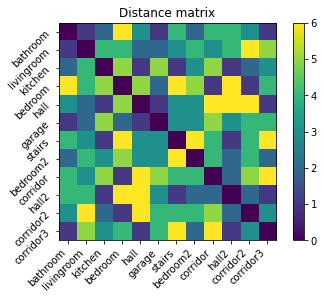

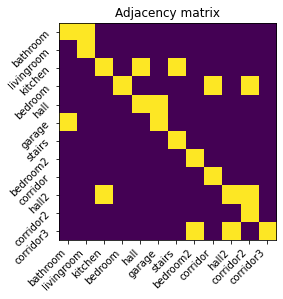

In [2]:
n_rooms = 12
largest_distance = np.sqrt(n_rooms*5).astype(int)
n_sensors = int(n_rooms/2)+2
house = RandomHouse(n_rooms, largest_distance=largest_distance,
              n_sensors=n_sensors, random_seed=43)
    
draw_matrix(house.distance_m, house.room_names, title='Distance matrix')
draw_matrix(house.adjacency_m, house.room_names, title='Adjacency matrix')

# Distances graph

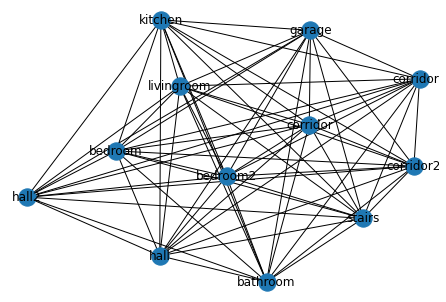

In [3]:
graph = nx.from_numpy_matrix(house.distance_m)
graph = nx.relabel.relabel_nodes(graph, {i:name for i, name in enumerate(house.room_names)})
pos=nx.spring_layout(graph)
nx.draw(graph, pos)
labels = nx.draw_networkx_labels(graph, pos)

# Adjacency graph

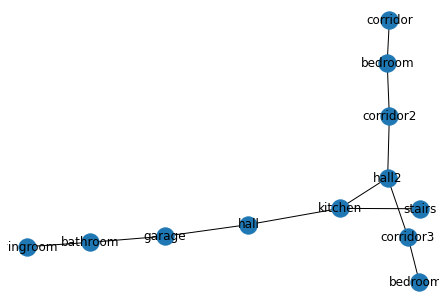

In [4]:
G = nx.from_numpy_matrix(house.adjacency_m)
G = nx.relabel.relabel_nodes(G, {i:name for i, name in enumerate(house.room_names)})
pos=nx.spring_layout(G)
nx.draw(G, pos)
labels = nx.draw_networkx_labels(G, pos)

# Simulate walkaround per room

Here we simulate a walkaround for each room of the synthetic house. And add receiver sensors in a number of rooms, indicated with a red star in the room's cohordinates (0, 0).

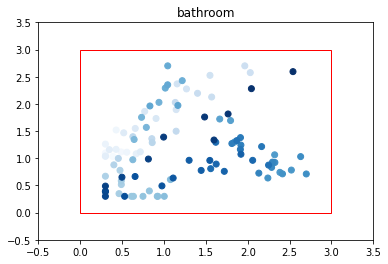

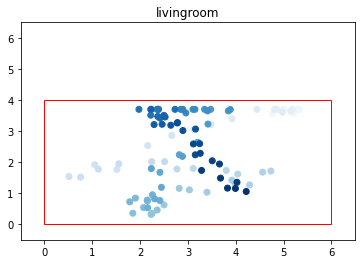

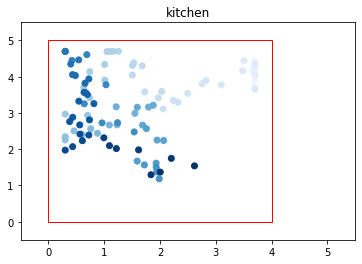

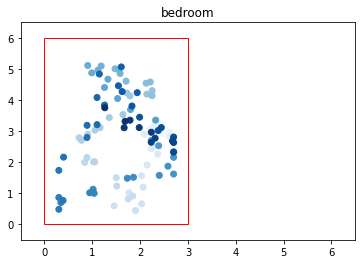

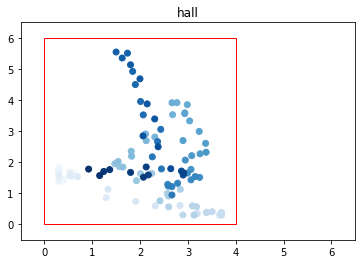

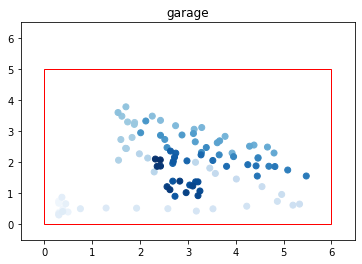

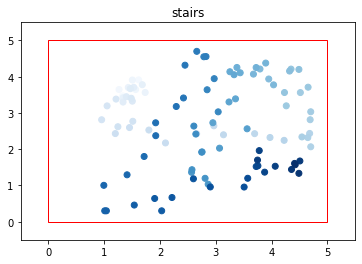

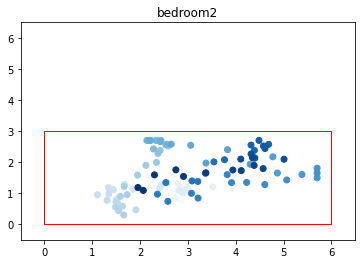

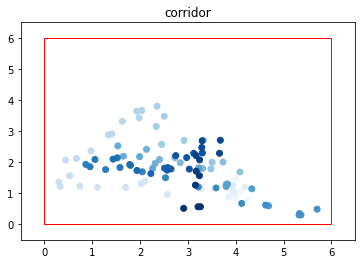

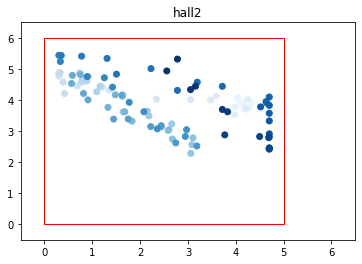

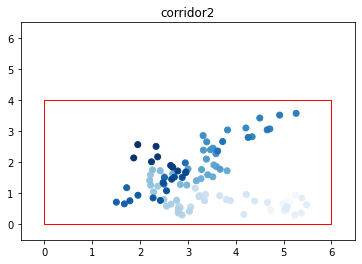

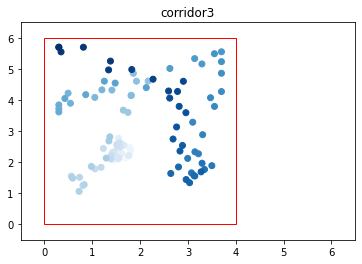

In [5]:
walkaround_dict = house.retrieve_walkaround(number=0, n_locations=10, samples_inbetween=10)

for i, (room_name, walkaround) in enumerate(walkaround_dict.items()):
    plot_room_walkaround(walkaround['path'], house.room_dimensions[i],
                         title=room_name,
                         lines=False)

# Summary of walkarounds

The following figure shows the x and y coordinates with respect to the origin of each room.

Text(0, 0.5, 'Room fine locations')

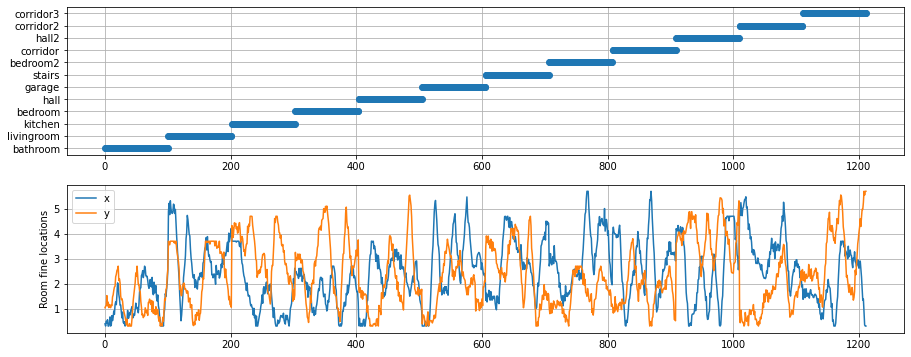

In [6]:
X, y = house.walkaround_as_x_y(0, 'path')

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y, 'o')
ax.grid()
ax.set_yticks(range(n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2)
ax.grid()
ax.plot(X)
ax.legend(['x', 'y'])
ax.set_ylabel('Room fine locations')

# Summary euclidean distances to room1

Here we show the euclidean distances to the origin of the first room of the house for all the walkarounds

Text(0, 0.5, 'Eucl. dist. to bathroom')

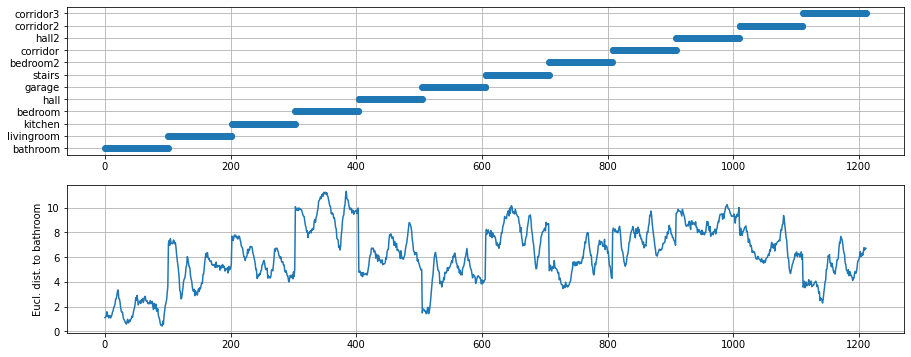

In [7]:
eucl_distances = np.sqrt(np.sum(X**2, axis=1))
eucl_distances += house.distance_m[0][y]

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y, 'o')
ax.grid()
ax.set_yticks(range(n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2)
ax.grid()
ax.plot(eucl_distances)
ax.set_ylabel('Eucl. dist. to {}'.format(house.room_names[0]))

# Distances to sensors

Here we show the euclidean distance to each sensor, considering the distances between rooms.

Text(0, 0.5, 'Eucl. distance to sensors')

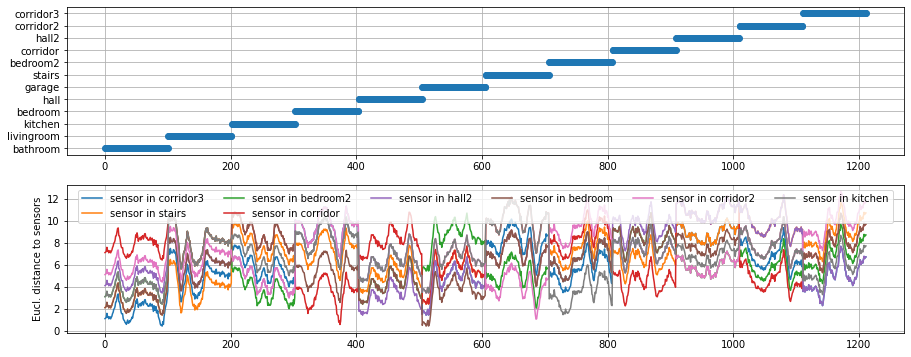

In [8]:
X_dist, y = house.get_sensor_distances(0)

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y, 'o')
ax.grid()
ax.set_yticks(range(house.n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2)
ax.grid()
ax.plot(X_dist)
ax.legend(['sensor in ' + room for room in house.sensor_locations], loc='upper center', ncol=6)
ax.set_ylabel('Eucl. distance to sensors')

# Path loss model

we apply a path loss model to compute the RSSI signal to each sensor, considering a random constant loss per sensor, as well as a random loss per exact x, y position

Text(0, 0.5, 'RSSI')

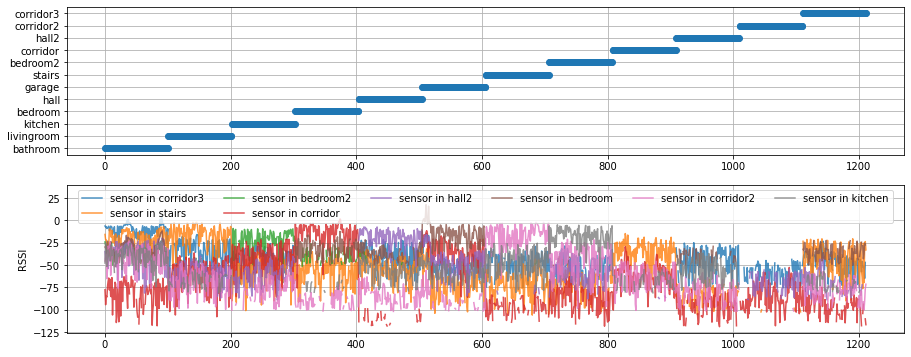

In [9]:
X_rssi, y = house.get_sensor_rssi(0)

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y, 'o')
ax.grid()
ax.set_yticks(range(house.n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2)
ax.grid()
ax.plot(X_rssi, alpha=0.8)
ax.set_ylim((ax.get_ylim()[0], 40))
ax.legend(['sensor in ' + room for room in house.sensor_locations], loc='upper center', ncol=6)
ax.set_ylabel('RSSI')

# Aggregating RSSI

In order to train a model, we will aggregate the raw RSSI data, as it proves to be very noisy. This is the case in real data as well.

Text(0, 0.5, 'Mean RSSI')

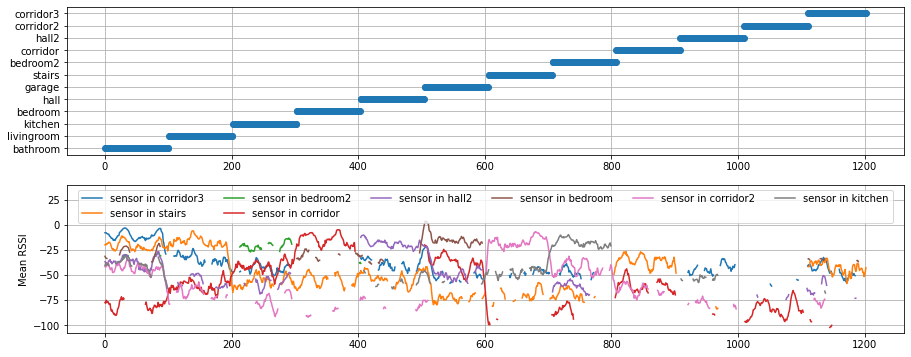

In [10]:
def rolling_window(a, window):
    """Creates a rolling window matrix from an original matrix
    Parameters
    ----------
    a : ndarray
    window : int
        Window size
    Returns
    -------
    matrix : ndarray
        With same shape as the original matrix a with an additional dimension
    """
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def get_subsequences(x, y, window=10):
    """
    Parameters
    ----------
    x : ndarray
        Matrix of shape (S,D) where S is the number of samples and D is the
        number of dimensions.
    y : ndarray
        Matrix of shape (S,C) where S is the number of samples and C is the
        number of classes.
    window : integer, optional
        Number of subsequences to obtain.
    Returns
    -------
    x_seq : ndarray
        Matrix of shape (S-window/2,D,window) where the first dimension
        corresponds to a copy of the original matrix swifted one position.
    y_seq : ndarray
        Matrix of shape (S-window/2,D,window) where the first dimension
        corresponds to a copy of the original matrix swifted one position.
    """
    x_seq = rolling_window(x.T, window)
    y_seq = rolling_window(y.T, window)

    x_seq = np.swapaxes(x_seq, 0, 1)
    y_seq = np.swapaxes(y_seq, 0, 1)
    return x_seq, y_seq

X_sub, y_sub = get_subsequences(X_rssi, y, window=10)
X_train = np.mean(X_sub, axis=-1)
y_train = y_sub[0,:]

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y_train, 'o')
ax.grid()
ax.set_yticks(range(house.n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2)
ax.grid()
ax.plot(X_train)
ax.set_ylim((ax.get_ylim()[0], 40))
ax.legend(['sensor in ' + room for room in house.sensor_locations], loc='upper center', ncol=6)
ax.set_ylabel('Mean RSSI')

# Create a second walkaround

Text(0, 0.5, 'Mean RSSI')

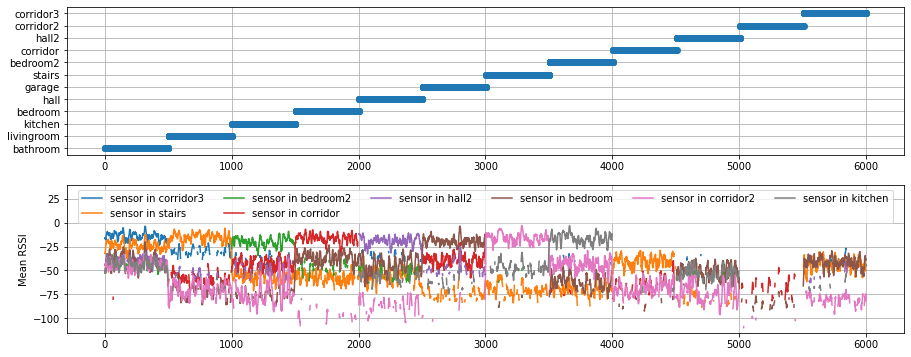

In [11]:
walkaround = house.retrieve_walkaround(number=1, n_locations=50)
X_test, y_test = house.get_sensor_rssi(number=1)
X_test, y_test = get_subsequences(X_test, y_test, window=10)
X_test = np.mean(X_test, axis=-1)
y_test = y_test[0,:]

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y_test, 'o')
ax.grid()
ax.set_yticks(range(house.n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2)
ax.grid()
ax.plot(X_test)
ax.set_ylim((ax.get_ylim()[0], 40))
ax.legend(['sensor in ' + room for room in house.sensor_locations], loc='upper center', ncol=6)
ax.set_ylabel('Mean RSSI')

# Model training and evaluation

Here we train a model in the aggregated RSSI data, and show the cross-validation performance

In [12]:
import sys
sys.path.append('../')
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from evalbd.models import obtain_training_pipeline, DropAtRandom
from evalbd.plots import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict

cv = StratifiedKFold(n_splits=5, shuffle=False)

drop_proportion = 0.0
clf = RandomForestClassifier(n_estimators=200)
steps = [('missing', DropAtRandom(proportion=drop_proportion)),    
         ('imputer', SimpleImputer(missing_values=np.nan,    
                                   strategy='constant',    
                                   fill_value=-120)),    
         ('clf', clf)]
pip_params = {}

pipeline = Pipeline(steps)
grid = GridSearchCV(pipeline, param_grid=pip_params, cv=cv,
                    refit=True, iid=True)

grid.fit(X_train, y_train)
scores = cross_val_score(grid, X_train, y_train, cv=cv)
y_pred = cross_val_predict(grid, X_train, y_train, cv=cv)
cm = confusion_matrix(y_train, y_pred, labels=range(len(house.room_names)))
fig = plot_confusion_matrix(cm, house.room_names, normalize=False,
                           title='CV Acc = {:.01f}%'.format(
                               100*cm.diagonal().sum()/cm.sum()))

# Test performance
y_pred = grid.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=range(len(house.room_names)))
acc = 100*cm.diagonal().sum()/cm.sum()
fig = plot_confusion_matrix(cm, house.room_names, normalize=False,
                           title='Test Acc = {:.01f}%'.format(acc))

ModuleNotFoundError: No module named 'evalbd'